## Netflix EDA, Recommendation 

- 데이터의 선택 이유
    - 텍스트 데이터의 전처리와 시각화를 경험해보기 위함.
- 진행 방향
    - 데이터 특징 파악 및 다양한 시각화를 이용한 EDA 진행
    - (가능하다면) IMDB 데이터셋을 Join해서 추가 변수를 불러와 활용해보기.
    - 간단한 NLP(Natural Langurage Processing) Analysis을 진행하고, cosine similarity를 이용한 추천 모델 제작해보기.
- 실행 계획
    - 1) 간단한 Data Exploration
    - 2) IMDB 데이터 Join해서 결측값 채우기 및 추가 변수 활용 (`imdb movies.csv`-영화 평점)
    - 3) Content-Based Recommendation 모델
        - TF-IDF matrix, cosine similarity
- 데이터 Reference
    - 1) Netflix Movies and TV Shows(https://www.kaggle.com/datasets/shivamb/netflix-shows)
    - 2) IMDB Movies Dataset(https://www.kaggle.com/datasets/mirajshah07/netflix-dataset
        - IMDB(https://www.imdb.com/)-> 영화/드라마 리뷰 및 정보 사이트
        - Netflix 데이터셋에는 없는 평점 데이터와 결측값을 처리하는 데에 사용하기 위한 추가 데이터입니다.

In [1]:
# import packages (python 3.10)
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Reference: https://www.kaggle.com/code/niharika41298/netflix-visualizations-recommendation-eda/notebook

In [2]:
# load dataset
netflix_df = pd.read_csv("./dataset/netflix_titles.csv")
netflix_df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


### Data Exploration

In [3]:
# Check types and non-null count for each columns 
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [4]:
# Determine unique values for 'type' column
netflix_df["type"].value_counts() # value_counts: pd.Series에서 고유한 값들의 각 개수를 알려준다. 

Movie      6131
TV Show    2676
Name: type, dtype: int64

In [6]:
# Determine unique values for 'rating' column
netflix_df["rating"].value_counts()

TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: rating, dtype: int64

In [7]:
# Check earliest and latest release_year
print(netflix_df["release_year"].min(), "~", netflix_df["release_year"].max())

1925 ~ 2021


### Add IMDB data to get ratings and deal with missing values
- 평점을 얻어오기 위해 IMDB movies 데이터셋을 추가해서 사용합니다. (Inner Join)
- title(original_title)로 동일한 영화를 매치해서 Netflix 데이터셋에 있는 결측값을 처리하는데 이용합니다.

In [5]:
# Load IMDB dataset (https://www.kaggle.com/datasets/mirajshah07/netflix-dataset?rvi=1)
imdb_titles = pd.read_csv("./dataset/IMDB movies.csv")

C:\Users\PC\AppData\Local\Temp\ipykernel_60640\952706796.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_titles = pd.read_csv("./dataset/IMDB movies.csv")


In [6]:
imdb_titles.head(3)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,26-12-1906,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,19-08-1911,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0


In [7]:
# Select necessary columns
imdb_titles = imdb_titles[["title", "original_title", "year", "country", "director", "actors", "avg_vote"]]

In [8]:
# Drop duplicated values based on title, year, and avg_vote
imdb_titles = imdb_titles.drop_duplicates(subset=["title","year","avg_vote"])
imdb_titles.shape

(85852, 7)

In [11]:
# Now, merge joint_data and netflix_df again
# to get the content that has both IMDB ratings and also available on Netflix.
# Inner Join: 교집합처럼 넷플릭스 데이터(왼쪽)와 imdb 데이터(오른쪽)에 모두 있는 영화의 정보만을 가져옵니다.
# 영화 제목을 기준으로 하는데, netflix 데이터에서는 영화 제목 column 이름이 'title', imdb에서는 'orignal_title'로 되어 있습니다.
netflix_joint_df = netflix_df.merge(imdb_titles, left_on = "title", right_on="original_title", how = "inner")

In [14]:
netflix_joint_df.info()
# 양쪽 데이터 모두에서 동일한 column명이 있다면 _x, _y를 자동으로 붙혀줍니다. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4079 entries, 0 to 4078
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   show_id         4079 non-null   object 
 1   type            4079 non-null   object 
 2   title_x         4079 non-null   object 
 3   director_x      4077 non-null   object 
 4   cast            4079 non-null   object 
 5   country_x       4075 non-null   object 
 6   date_added      4076 non-null   object 
 7   release_year    4079 non-null   int64  
 8   rating          4078 non-null   object 
 9   duration        4079 non-null   object 
 10  listed_in       4079 non-null   object 
 11  description     4079 non-null   object 
 12  title_y         4079 non-null   object 
 13  original_title  4079 non-null   object 
 14  year            4079 non-null   object 
 15  country_y       4074 non-null   object 
 16  director_y      4076 non-null   object 
 17  actors          4078 non-null   o

In [14]:
# Check missing values
netflix_joint_df.isnull().sum()

show_id             0
type                0
title_x             0
director_x        471
cast               83
country_x         118
date_added          3
release_year        0
rating              1
duration            0
listed_in           0
description         0
title_y             0
original_title      0
year                0
country_y           5
director_y          3
actors              1
avg_vote            0
dtype: int64

In [12]:
"""Netflix 데이터 결측값 처리"""
# 1) Deal with missing values using columns from 'imdb_titles' dataset 
# IMDB 데이터셋에서 불러온 columns들에 있는 값을 이용해서 기존 Netflix 데이터에 있던 결측값을 대체합니다. 
netflix_joint_df['director_x'] = netflix_joint_df.apply(lambda row: row['director_y'] if pd.isnull(row['director_x']) else row['director_x'], axis = 1)
netflix_joint_df['cast'] = netflix_joint_df.apply(lambda row: row['actors'] if pd.isnull(row['cast']) else row['cast'], axis = 1)
netflix_joint_df['country_x'] = netflix_joint_df.apply(lambda row: row['country_y'] if pd.isnull(row['country_x']) else row['country_x'], axis = 1)

In [13]:
netflix_joint_df.isnull().sum()

show_id           0
type              0
title_x           0
director_x        2
cast              0
country_x         4
date_added        3
release_year      0
rating            1
duration          0
listed_in         0
description       0
title_y           0
original_title    0
year              0
country_y         5
director_y        3
actors            1
avg_vote          0
dtype: int64

In [15]:
# Drop unnecessary columns 
netflix_joint_df = netflix_joint_df.drop(columns=['title_y', 'original_title', 'country_y', 'year', 'director_y', 'actors'])

In [16]:
# 2) Drop remaning NaN values
# 이후 남아있는 결측값의 수가 1~4개이기 때문에 추가로 처리를 하지 않고 Drop합니다. 
netflix_joint_df = netflix_joint_df.dropna()
netflix_joint_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4069 entries, 0 to 4078
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   show_id       4069 non-null   object 
 1   type          4069 non-null   object 
 2   title_x       4069 non-null   object 
 3   director_x    4069 non-null   object 
 4   cast          4069 non-null   object 
 5   country_x     4069 non-null   object 
 6   date_added    4069 non-null   object 
 7   release_year  4069 non-null   int64  
 8   rating        4069 non-null   object 
 9   duration      4069 non-null   object 
 10  listed_in     4069 non-null   object 
 11  description   4069 non-null   object 
 12  avg_vote      4069 non-null   float64
dtypes: float64(1), int64(1), object(11)
memory usage: 445.0+ KB


Now we have 4,069 cleaned entries

## Visualizations

In [17]:
# Top 10 rated movies or tv shows on Netflix using sunburst chart
# 가장 평점이 좋은 영화나 드라마 10개를 시각화합니다.
netflix_joint_df = netflix_joint_df.sort_values(by="avg_vote", ascending=False)
top_rated=netflix_joint_df[0:10]
fig =px.sunburst(
    top_rated,
    path=['title_x','country_x'],
    values='avg_vote',
    color='avg_vote',
    title="Top 10 rated movies on Netflix")
fig.show()

In [18]:
# Top 10 highest rated countries
# 각 나라별 영화의 개수를 측정하고, 이 중 가장 많은 10개의 나라만 보여줍니다.
country_count=netflix_joint_df['country_x'].value_counts().sort_values(ascending=False)
country_count=pd.DataFrame(country_count)
topcountries=country_count[0:11]
topcountries

,country_x
United States,1444
India,772
United Kingdom,157
Canada,73
"United Kingdom, United States",68
Philippines,57
France,48
South Korea,47
USA,46
Turkey,45


In [19]:
# 국가 이름도 ','로 구분이 되어 있어서, text split처리가 필요해 보입니다.
country_count

,country_x
United States,1444
India,772
United Kingdom,157
Canada,73
"United Kingdom, United States",68
...,...
"China, United States, United Kingdom",1
Guatemala,1
"Canada, South Korea, United States",1
"United Kingdom, Canada, United States, Cayman Islands",1


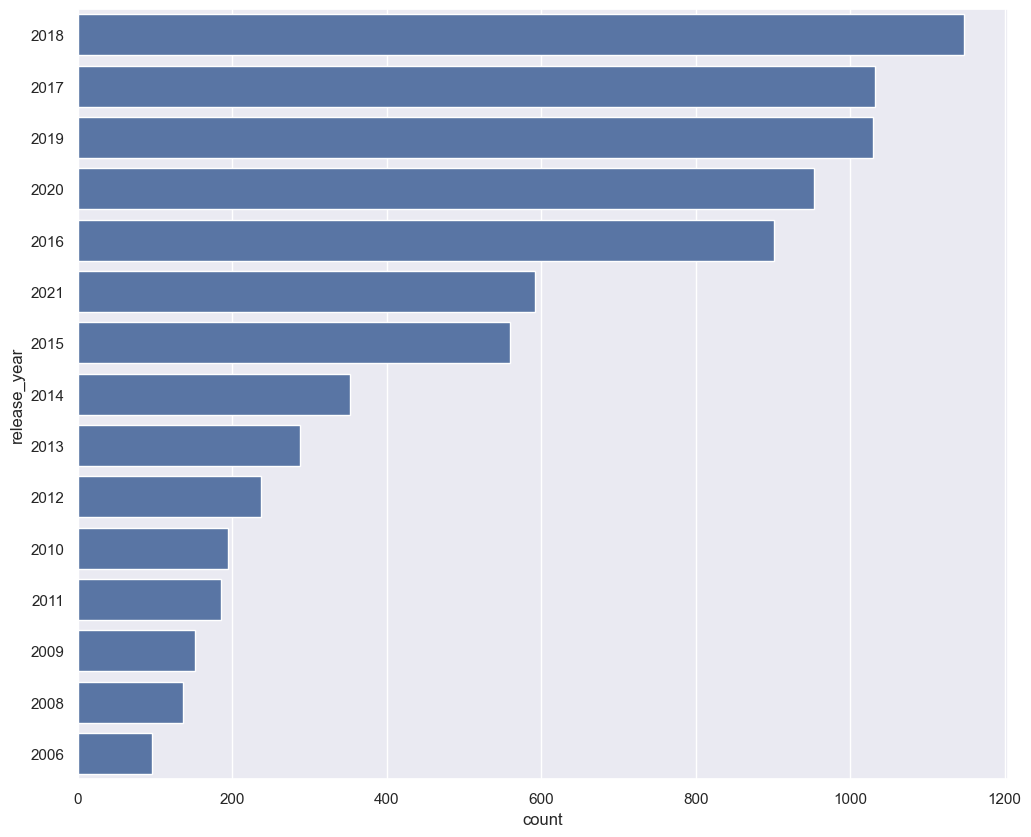

In [20]:
# How many movies were released in year-wise?
# 가장 많은 영화를 상영했던 연도를 보여줍니다. (연도 순으로 차트를 보여주는 것도 좋을 것 같음)
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y="release_year", data=netflix_df, order=netflix_df['release_year'].value_counts().index[0:15])

In [21]:
# How long does the movie play? 영화의 상영 시간 분포도를 구해봅니다.
# 1) Devide movie and tv shows (Since movie is counted by minutes and tv shows with seasons)
netflix_movies = netflix_joint_df[netflix_joint_df['type'] == 'Movie']
netflix_shows = netflix_joint_df[netflix_joint_df['type'] == 'TV Show']
print(netflix_movies.shape, netflix_shows.shape)

(3573, 13) (496, 13)


In [22]:
# Transform to int by removing 'min' after the numbers in 'duration'
netflix_movies['duration']=netflix_movies['duration'].str.replace(' min','')
netflix_movies['duration'] = netflix_movies['duration'].astype(str).astype(int)

C:\Users\PC\AppData\Local\Temp\ipykernel_60640\1747989587.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp\ipykernel_60640\1747989587.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\PC\AppData\Local\Temp\ipykernel_43240\2358253589.py:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




<AxesSubplot: xlabel='duration', ylabel='Density'>

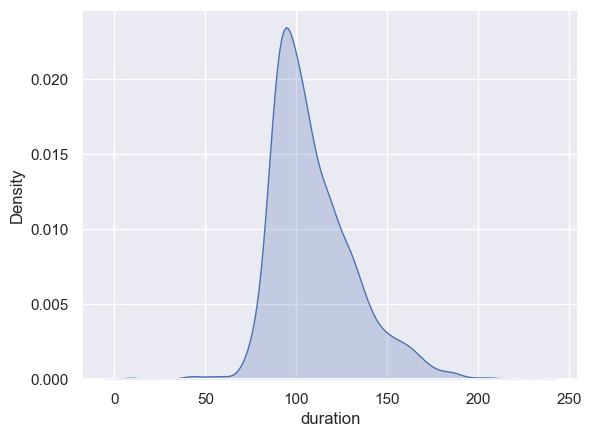

In [46]:
# Distribution of duration (play time)
sns.set(style="darkgrid")
sns.kdeplot(data=netflix_movies['duration'], shade=True)

### WordCloud
- 일부 변수들은 ','로 한 행에 여러 값이 들어가있음. 
- split 처리가 필요함.

In [24]:
# ! pip install wordcloud 

   ---------------------------------------- 152.1/152.1 kB 9.5 MB/s eta 0:00:00


In [25]:
from collections import Counter

genres=list(netflix_movies['listed_in']) # listed_in: genre
gen=[]

# Separate genres based on ',' 
for i in genres:
    i=list(i.split(','))
    for j in i:
        gen.append(j.replace(' ',""))
g=Counter(gen) # 워드클라우드를 만들기 위해 dataframe을 Counter함수를 사용해서 자동으로 dictionary형으로 변환 

In [26]:
gen

['Action&Adventure',
 'Sci-Fi&Fantasy',
 'ClassicMovies',
 'Dramas',
 'ClassicMovies',
 'CultMovies',
 'Dramas',
 'Action&Adventure',
 'Sci-Fi&Fantasy',
 'Thrillers',
 'Action&Adventure',
 'Sci-Fi&Fantasy',
 'Action&Adventure',
 'Sci-Fi&Fantasy',
 'Dramas',
 'InternationalMovies',
 'ClassicMovies',
 'Comedies',
 'InternationalMovies',
 'Dramas',
 'InternationalMovies',
 'Thrillers',
 'InternationalMovies',
 'RomanticMovies',
 'Dramas',
 'IndependentMovies',
 'InternationalMovies',
 'Dramas',
 'InternationalMovies',
 'Dramas',
 'IndependentMovies',
 'InternationalMovies',
 'Dramas',
 'Thrillers',
 'Dramas',
 'IndependentMovies',
 'InternationalMovies',
 'HorrorMovies',
 'InternationalMovies',
 'Thrillers',
 'Action&Adventure',
 'IndependentMovies',
 'Comedies',
 'InternationalMovies',
 'Music&Musicals',
 'Dramas',
 'IndependentMovies',
 'InternationalMovies',
 'Dramas',
 'Dramas',
 'InternationalMovies',
 'Dramas',
 'IndependentMovies',
 'InternationalMovies',
 'Dramas',
 'International

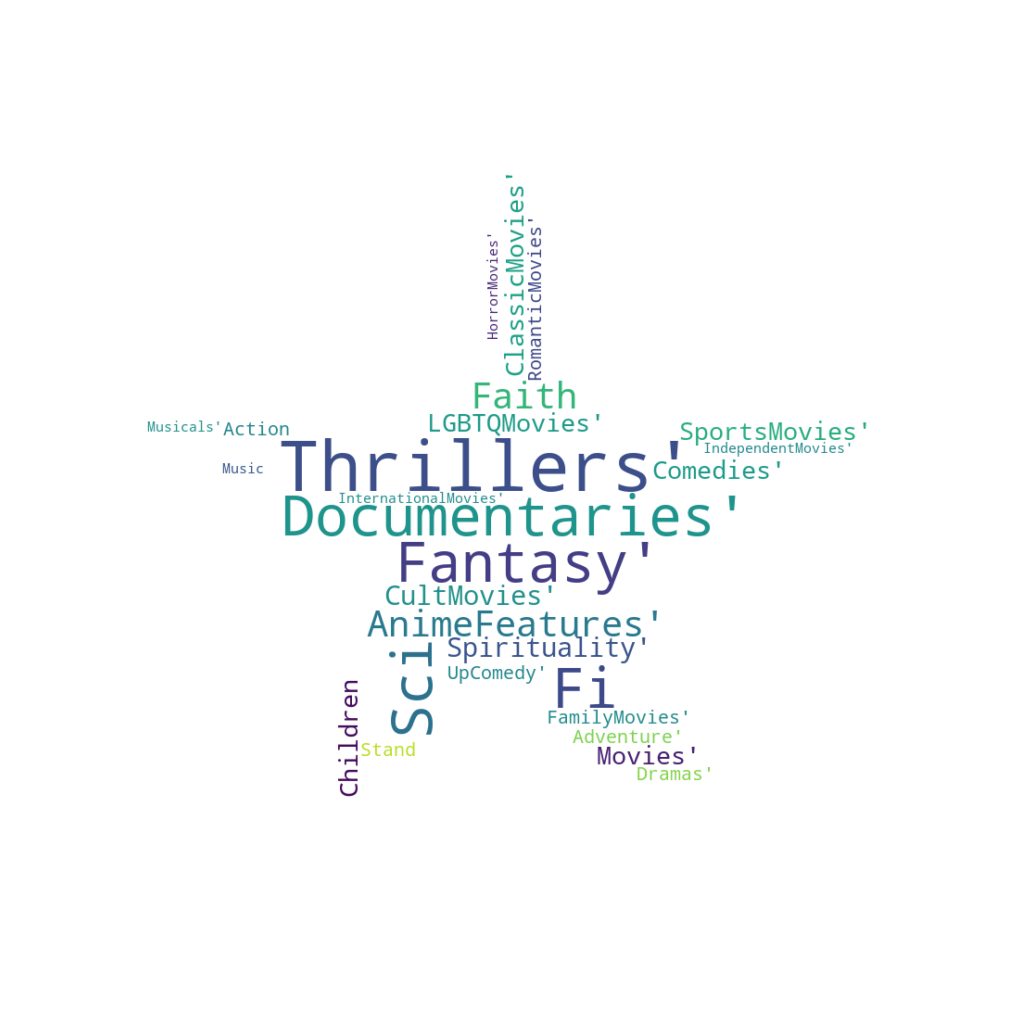

In [29]:
# Create wordcloud for genres to see what kinds of genres are dominated
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

text = list(set(gen))
plt.rcParams['figure.figsize'] = (13, 13)

# assigning shape to the word cloud
mask = np.array(Image.open('./mask_image/star.png'))
wordcloud = WordCloud(max_words=1000000,background_color="white",mask=mask).generate(str(text))

plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_60640\3580691374.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, 1.0, 'Genres')

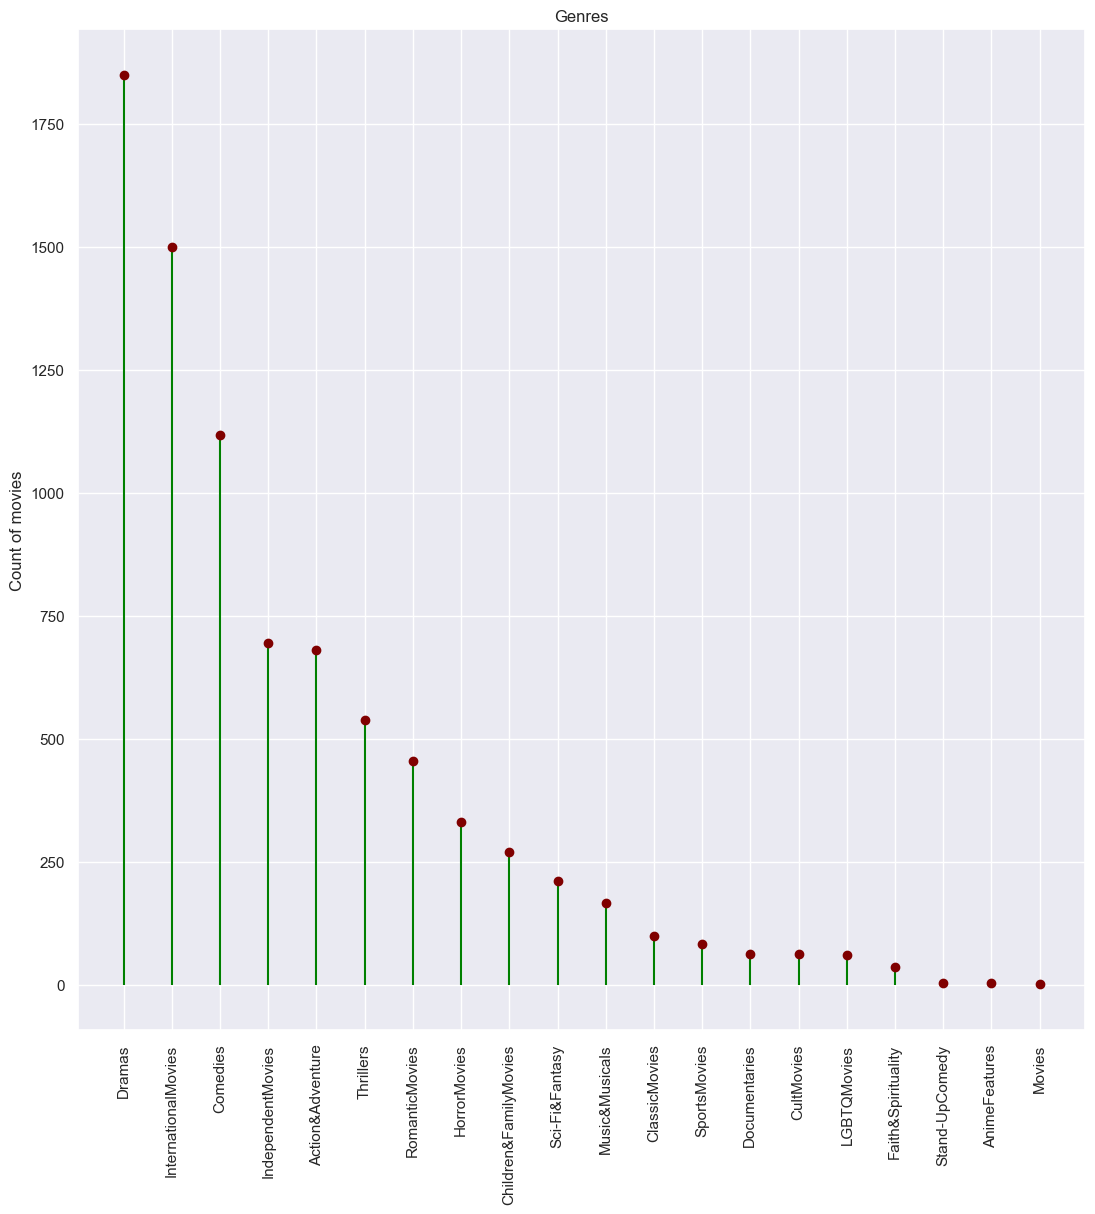

<Figure size 1000x1000 with 0 Axes>

In [31]:
# Lolipop plots to see the counts of movies based on genres
g={k: v for k, v in sorted(g.items(), key=lambda item: item[1], reverse= True)}

fig, ax = plt.subplots()

fig = plt.figure(figsize = (10, 10))
x=list(g.keys())
y=list(g.values())
ax.vlines(x, ymin=0, ymax=y, color='green')
ax.plot(x,y, "o", color='maroon')
ax.set_xticklabels(x, rotation = 90)
ax.set_ylabel("Count of movies")
# set a title
ax.set_title("Genres")

## Content-Based Recommendation System
- Content-Based Filtering: 사용자가 소비한 아이템에 대해 아이템의 내용(content)이 비슷하거나 특별한 관계가 있는 다른 아이템을 추천하는 방법
- using TF-IDF(Term Frequency-Inverse Document Frequency) scores and
- consine similarity

1) Use 'description' to recommend similar movies or TV shows
2) Strings handling (stopwords, empty string, etc.)
3) Create TF-IDF matrix 
4) Use consine similarity score to recommend

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

#removing stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(netflix_joint_df['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4069, 10226)

In [51]:
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(4069, 4069)

In [64]:
indices = pd.Series(netflix_joint_df.index, index=netflix_joint_df['title_x']).drop_duplicates()

def get_recommendations(title_x, cosine_sim=cosine_sim):
    idx = indices[title_x]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return netflix_joint_df[['title_x', 'director_x', 'listed_in', 'avg_vote']].iloc[movie_indices].sort_values('avg_vote', ascending = False)

In [65]:
get_recommendations("Pulp Fiction")

,title_x,director_x,listed_in,avg_vote
388,Tottaa Pataaka Item Maal,Aditya Kripalani,"Dramas, Independent Movies, International Movies",8.0
2455,Tallulah,Sian Heder,"Dramas, Independent Movies",6.7
983,Wira,Adrian Teh,"Action & Adventure, Dramas, International Movies",6.3
4069,Young Adult,Jason Reitman,"Comedies, Dramas, Independent Movies",6.2
304,Life of Crime,Daniel Schechter,"Comedies, Independent Movies",5.8
197,Brick Mansions,Camille Delamarre,"Action & Adventure, International Movies",5.7
2394,3 Türken & ein Baby,Sinan Akkuş,"Comedies, International Movies",5.5
1012,The Stolen,Niall Johnson,Dramas,5.2
2854,Dog Eat Dog,Paul Schrader,"Dramas, Thrillers",4.7
3992,Two Graves,Gary Young,Thrillers,4.2
